In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

## Dataset

In [2]:
!wget 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv' -O '../datasets/credit_card.csv'

--2022-10-03 17:44:02--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘../datasets/credit_card.csv’

../datasets/credit_ 100%[===================>]  71,53K  --.-KB/s    in 0,01s   

2022-10-03 17:44:03 (4,77 MB/s) - ‘../datasets/credit_card.csv’ saved [73250/73250]



## Preparation

In [3]:
df = pd.read_csv('../datasets/credit_card.csv')

In [4]:
df.card = (df.card == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

    For each numerical variable, use it as score and compute AUC with the card variable.
    Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. -df_train['expenditure'])

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

-    reports

-    dependents

-    active

-    share


# ?

## Training the model

From now on, use these columns only:

["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)


In [6]:
cols = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]

In [7]:
def modelize(df_train, y_train, cols, C=1.0):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    return dv, model

In [8]:
def predict(df_val, dv, model, cols):
    val_dict = df_val[cols].to_dict(orient='records')
    X_val = dv.transform(val_dict)

    return model.predict_proba(X_val)[:, 1]

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

-    0.615

-    0.515

-    0.715

-    0.995


In [9]:
dv, model = modelize(df_train, y_train, cols)
y_pred = predict(df_val, dv,model, cols)
score = roc_auc_score(y_val, y_pred)
round(score, 3)

0.995

## Question 3

Now let's compute precision and recall for our model.

    Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
    For each threshold, compute precision and recall
    Plot them

At which threshold precision and recall curves intersect?

-    0.1

-    0.3

-    0.6

-    0.8


In [10]:
precision = []
recall = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    precision.append(p)
    recall.append(r)

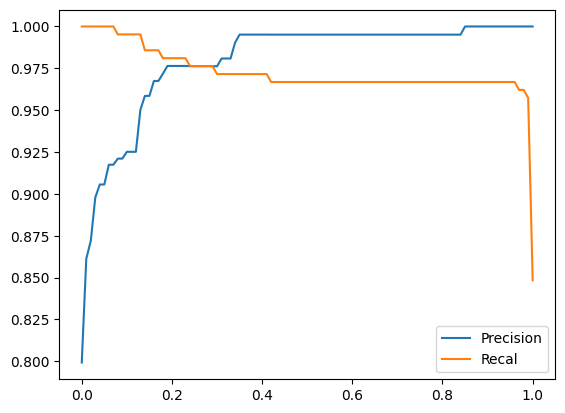

In [11]:
plt.plot(thresholds, precision, label='Precision')
plt.plot(thresholds, recall, label='Recal')
plt.legend()

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both


Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold F1 is maximal?

-    0.1

-    0.4

-    0.6

-    0.7


In [12]:
f1_score = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1_score.append((2*p*r)/(p+r))

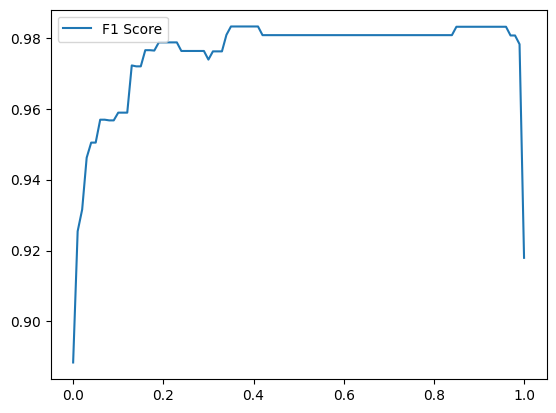

In [13]:
plt.plot(thresholds, f1_score, label='F1 Score')
plt.legend()

In [14]:
f1_score[40] == max(f1_score)

True

## Question 5

Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

    Iterate over different folds of df_full_train
    Split the data into train and validation
    Train the model on train with these parameters: LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

    0.003
    0.014
    0.09
    0.24


In [15]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = modelize(df_train, y_train, cols)
    y_pred = predict(df_val, dv, model, cols)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [16]:
round(np.std(scores),3)

0.003

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

    Iterate over the following C values: [0.01, 0.1, 1, 10]
    Initialize KFold with the same parameters as previously
    Use these parametes for the model: LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

    0.01
    0.1
    1
    10


In [17]:
for C in [0.01, 0.1, 1, 10]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = modelize(df_train, y_train, cols, C=C)
        y_pred = predict(df_val, dv, model, cols)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s : %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 : 0.992 +- 0.006
C=0.1 : 0.995 +- 0.004
C=1 : 0.996 +- 0.003
C=10 : 0.996 +- 0.003
